In [1]:
# -*- coding: utf-8 -*-

# Phishing Email Detection with Large Language Model
## Deep Learning Final Project

**Author:** Fatih Uenal

**Course:** CU Boulder MSc Computer Science & AI  

**Date:** 04.07.2025

**GitHub Repository:** [Github Repo Link](https://github.com/FUenal/cu-boulder-csca-5642-deep-learning-final)

----

### **Executive Summary**

This Jupyter notebook presents a comprehensive study on the application of Large Language Models (LLMs) for phishing email detection, with a particular focus on their performance in **few-shot learning scenarios**. Recognizing the escalating threat of sophisticated phishing attacks, this project benchmarks the capabilities of two representative LLMs—a **fine-tuned DistilBERT model (`Phishing-DistilBERT-v2.4.1`)** and a **non-fine-tuned BERT base model (`bert-base-uncased`)**—against highly efficient **traditional machine learning baselines (XGBoost and LightGBM)**.

The study leverages four publicly available email and SMS spam datasets to ensure diverse evaluation. Through a streamlined methodology focusing on training with limited samples (ranging from 4 to 256), the project demonstrates that:

* **LLMs exhibit strong performance in few-shot settings**, often achieving high F1 scores even with minimal training data, thanks to their robust pre-trained linguistic understanding.
* While **LLMs incur higher training costs** compared to baselines, their **inference times are remarkably fast**, making them practical for real-time deployment in cybersecurity systems.
* **Traditional machine learning models remain highly competitive and computationally efficient**, especially as the number of training samples increases.

This research highlights the significant potential of LLMs as a powerful new defense against evolving phishing threats, particularly in data-scarce environments, while providing a clear comparative analysis with established methods.

---

# Phishing Email Detection with Large Language Models

This Jupyter notebook is a self-contained environment for performing exploratory data analysis (EDA), model training, and evaluation for phishing email detection.

This notebook:
- Analyzes a specifically fine-tuned model:
    - `cybersectony/phishing-email-detection-distilbert_v2.4.1`
- With a baselin LLM:
    -  `bert-base-uncased`
- Includes a baseline model:
    - XGBoost and LightGBM
- Implement F1 score, Precision, and Recall as primary evaluation metrics.
- Generate specific EDA visualizations, including pie charts for dataset distribution and plots for training/inference time vs. training samples.
- Produce a main results visualization comparing F1 scores across models and training samples.

**GitHub Repository:** [Your GitHub Repository URL Here] (Remember to replace this with your actual GitHub repo URL)

## Table of Contents

1.  Problem Description
2.  Setup and Dependencies
3.  Data Collection and Provenance
4.  Exploratory Data Analysis (EDA)
5.  Model Building and Training (Deep Learning Models)
    -   Baseline Models
    -   Large Language Models (LLMs)
6.  Results and Discussion
7.  Conclusion

---

## 1. Problem Description

The proliferation of phishing attacks through emails poses a significant threat to individuals and organizations, leading to financial losses, data breaches, and reputational damage. Traditional spam detection methods often struggle with the evolving nature of these sophisticated attacks. This project aims to investigate the effectiveness of Large Language Models (LLMs) in detecting phishing emails, particularly in few-shot learning scenarios where labeled data might be scarce. I will compare the performance of various LLMs, including both pre-trained and fine-tuned models, against traditional machine learning baselines to determine their suitability for this critical cybersecurity task.

---

## 2. Setup and Dependencies

This section sets up the environment by installing necessary Python packages and importing the required libraries.


In [ ]:
# --- Kaggle Notebook Setup: Latest Compatible Versions ---
# This script installs all project dependencies, allowing pip to find the latest
# versions compatible with Kaggle's default Python 3.11 environment.
# This is necessary due to deep incompatibilities with older, strict version pins.

print("Installing project dependencies with latest compatible versions...")
# 1. Install scienceplots 
!pip install scienceplots==2.0.1 > /dev/null 2>&1
# 2. Install core dependencies, allowing pip to find the latest compatible versions.
!pip install --upgrade \
    torch \
    torchvision \
    torchaudio \
    transformers \
    datasets \
    evaluate \
    setfit \
    accelerate \
    sentence-transformers \
    > /dev/null 2>&1
# 3. Install other standard scientific/ML libraries, with specific versions for robustness.
!pip install \
    numpy==1.26.4 \
    scipy==1.13.0 \
    scikit-learn==1.4.2 \
    ipykernel==6.29.3 \
    matplotlib==3.8.4 \
    matplotlib-inline==0.1.6 \
    xgboost==2.0.3 \
    lightgbm==4.3.0 \
    catboost==1.2.2 \
    nltk==3.8.1 \
    pyarrow==16.1.0 \
    pandas==2.2.2 \
    > /dev/null 2>&1


print("Dependency installation complete. Verifying environment...")
# Verify the Python version
print("Active Python version:")
!python --version
# Verify versions of key libraries
print("\nVersions of key libraries:")
!pip show torch transformers datasets setfit numpy pandas scipy scikit-learn accelerate sentence-transformers

Installing project dependencies with latest compatible versions...
Dependency installation complete. Verifying environment...
Active Python version:
Python 3.11.11

Versions of key libraries:
Name: torch
Version: 2.7.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, easyocr, fastai, kornia, peft, pytorch-ignite, pytorch-lightning, sentence-transformers, stable-baselines3, timm, torchaudio, torchdat

In [ ]:
# --- Install LaTeX for SciencePlots ---
# Install a more comprehensive TeX Live distribution.
print("Installing more comprehensive LaTeX for matplotlib/scienceplots (might take a moment)...")
!sudo apt-get update -y > /dev/null 2>&1
!sudo apt-get install -y texlive-full-small dvipng > /dev/null 2>&1 # Use texlive-full-small
print("LaTeX installation complete.")

Installing more comprehensive LaTeX for matplotlib/scienceplots (might take a moment)...
LaTeX installation complete.


In [ ]:
### Import Libraries
import os
import glob
import tarfile
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots 
import numpy as np
import random
import torch
import copy
import time
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import (
    AutoModelForSequenceClassification,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    TrainerCallback,
    Seq2SeqTrainer,
    AutoTokenizer,
    Trainer,
)
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# --- CRITICAL FIX: Force Disable LaTeX rendering for matplotlib ---
plt.rcParams['text.usetex'] = False
# Set plot style. Some aspects of 'science' style might still use LaTeX internally
plt.style.use("science")
# Re-assert after style, in case 'science' style implicitly re-enables it for some elements.
plt.rcParams['text.usetex'] = False
# Optionally: print current usetex setting to debug
# print(f"matplotlib.rcParams['text.usetex']: {plt.rcParams['text.usetex']}")

2025-07-03 09:01:04.653520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751533265.010950      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751533265.112238      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Utility Functions

These functions are directly adapted from the `src/spamdetection/utils.py`, `src/spamdetection/preprocessing.py`, and `src/spamdetection/transforms.py` files in the original repository.

In [ ]:
# Define scoring metrics
SCORING = {
    "f1": f1_score,
    "precision": precision_score,
    "recall": recall_score,
    "accuracy": accuracy_score,
}

def set_seed(seed: int) -> None:
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def plot_loss(experiment: str, dataset_name: str, model_name: str) -> None:
    """Plot loss curve for LLMs."""
    try:
        log = pd.read_csv(f"outputs/csv/loss_{model_name}_{experiment}.csv")
        log = pd.DataFrame(log).iloc[:-1]

        train_losses = log["train_loss"].dropna().values
        eval_losses = log["eval_loss"].dropna().values
        x = np.arange(1, len(train_losses) + 1, step=1)

        with plt.style.context(["science", "high-vis"]):
            fig, ax = plt.subplots()
            plt.plot(x, train_losses, label="Training loss")
            plt.plot(x, eval_losses, label="Validation loss") 

            ax.set_title(f"{model_name} ({dataset_name.upper()})")
            ax.set_xticks(x, labels=range(1, len(x) + 1))
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend(loc="upper right")

            Path(f"outputs/pdf/").mkdir(parents=True, exist_ok=True)
            Path(f"outputs/png/").mkdir(parents=True, exist_ok=True)

            plt.savefig(f"outputs/pdf/loss_{model_name}_{experiment}.pdf", format="pdf")
            plt.savefig(f"outputs/png/loss_{model_name}_{experiment}.png", format="png", dpi=300)
            plt.show()
    except FileNotFoundError:
        print(f"Loss file not found for {model_name} in experiment {experiment}. Skipping loss plot.")

def save_scores(experiment: str, index: str, values: dict) -> None:
    """Log scores for individual models in the corresponding csv file."""
    llms_list = [
        "AcuteShrewdSecurity/Llama-Phishsense-1B",
        "ealvaradob/bert-finetuned-phishing",
        "meta-llama/Llama-Guard-3-1B",
        "cybersectony/phishing-email-detection-distilbert_v2.4.1",
        "bert-base-uncased", # Non-fine-tuned
        "roberta-base",     # Non-fine-tuned
        "google/flan-t5-base", # Non-fine-tuned
        "SetFit-mpnet", # Placeholder for SetFit
    ]
    models_list = ["NB", "LR", "KNN", "SVM", "XGBoost", "LightGBM"]

    Path(f"outputs/csv/").mkdir(parents=True, exist_ok=True)

    file = Path(f"outputs/csv/{experiment}.csv")
    if file.is_file():
        scores = pd.read_csv(f"outputs/csv/{experiment}.csv", index_col=0)
        scores.loc[index] = values
    else:
        if index in llms_list:
            scores = pd.DataFrame(
                index=llms_list,
                columns=list(SCORING.keys()) + ["training_time", "inference_time"],
            )
        else:
            scores = pd.DataFrame(
                index=models_list,
                columns=list(SCORING.keys()) + ["training_time", "inference_time"],
            )
        scores.loc[index] = values

    scores.to_csv(f"outputs/csv/{experiment}.csv")

# Preprocessing Functions
ps = PorterStemmer()

def init_nltk():
    """Download NLTK data."""
    try:
        nltk.data.find('corpora/stopwords')
    except nltk.downloader.DownloadError:
        nltk.download("punkt")
        nltk.download('stopwords')

def tokenize_words(text):
    """Tokenize words in text and remove punctuation."""
    text = word_tokenize(str(text).lower())
    text = [token for token in text if token.isalnum()]
    return text

def remove_stopwords(text):
    """Remove stopwords from the text."""
    text = [token for token in text if token not in stopwords.words("english")]
    return text

def stem(text):
    """Stem the text (originate => origin)."""
    text = [ps.stem(token) for token in text]
    return text

def transform_text(text):
    """Tokenize, remove stopwords, stem the text."""
    text = tokenize_words(text)
    text = remove_stopwords(text)
    text = stem(text)
    text = " ".join(text)
    return text

def transform_df(df):
    """Apply the transform function to the dataframe."""
    df["transformed_text"] = df["text"].apply(transform_text)
    return df

def encode_df(df, encoder=None):
    """Encode the features for training set."""
    if hasattr(encoder, "vocabulary_"):
        X = encoder.transform(df["transformed_text"]).toarray()
    else:
        X = encoder.fit_transform(df["transformed_text"]).toarray()
    y = df["label"].values
    return X, y, encoder

def get_dataset(name: str) -> pd.DataFrame:
    """Load a processed dataset based on a name."""
    return pd.read_csv(f"data/processed/{name}/data.csv").dropna()

def preprocess_enron() -> None:
    """Clean and rename the dataset and save it in data/processed."""
    Path("data/raw/enron").mkdir(parents=True, exist_ok=True)
    Path("data/processed/enron").mkdir(parents=True, exist_ok=True)

    url = "https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip"
    with urlopen(url) as zurl:
        with ZipFile(BytesIO(zurl.read())) as zfile:
            zfile.extractall("data/raw/enron")

    df = pd.read_csv("data/raw/enron/enron_spam_data.csv", encoding="ISO-8859-1")
    df = df.fillna("")
    df["text"] = df["Subject"] + df["Message"]
    df["label"] = df["Spam/Ham"].map({"ham": 0, "spam": 1})
    df = df[["text", "label"]]
    df = df.dropna()
    df = df.drop_duplicates()
    df.to_csv("data/processed/enron/data.csv", index=False)

def preprocess_ling() -> None:
    """Clean and rename the dataset and save it in data/processed."""
    Path("data/raw/ling").mkdir(parents=True, exist_ok=True)
    Path("data/processed/ling").mkdir(parents=True, exist_ok=True)

    url = "https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/lingspam_public.tar.gz"
    r = urlopen(url)
    t = tarfile.open(name=None, fileobj=BytesIO(r.read()))
    t.extractall("data/raw/ling")
    t.close()

    path = r"data/raw/ling/lingspam_public/bare/*/*"
    data = []
    for fn in glob.glob(path):
        label = 1 if "spmsg" in fn else 0
        with open(fn, "r", encoding="ISO-8859-1") as file:
            text = file.read()
            data.append((text, label))

    df = pd.DataFrame(data, columns=["text", "label"])
    df = df.dropna()
    df = df.drop_duplicates()
    df.to_csv("data/processed/ling/data.csv", index=False)

def preprocess_sms() -> None:
    """Clean and rename the dataset and save it in data/processed."""
    Path("data/raw/sms").mkdir(parents=True, exist_ok=True)
    Path("data/processed/sms").mkdir(parents=True, exist_ok=True)

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    with urlopen(url) as zurl:
        with ZipFile(BytesIO(zurl.read())) as zfile:
            zfile.extractall("data/raw/sms")

    df = pd.read_csv("data/raw/sms/SMSSpamCollection", sep="\t", header=None)
    df = df.drop_duplicates(keep="first")
    df = df.rename(columns={0: "label", 1: "text"})
    df["label"] = df["label"].map({"ham": 0, "spam": 1})
    df = df.dropna()
    df = df.drop_duplicates()
    df.to_csv("data/processed/sms/data.csv", index=False)

def preprocess_spamassassin() -> None:
    """Clean and rename the dataset and save it in data/processed."""
    Path("data/raw/spamassassin").mkdir(parents=True, exist_ok=True)
    Path("data/processed/spamassassin").mkdir(parents=True, exist_ok=True)

    urls = [
        "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2",
        "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2",
        "https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2",
        "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2",
        "https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2",
    ]
    for url in urls:
        r = urlopen(url)
        t = tarfile.open(name=None, fileobj=BytesIO(r.read()))
        t.extractall("data/raw/spamassassin")
        t.close()

    path = r"data/raw/spamassassin/*/*"
    data = []
    for fn in glob.glob(path):
        label = 0 if "ham" in fn else 1
        with open(fn, "r", encoding="ISO-8859-1") as file:
            text = file.read()
            data.append((text, label))

    df = pd.DataFrame(data, columns=["text", "label"])
    df = df.dropna()
    df = df.drop_duplicates()
    df.to_csv("data/processed/spamassassin/data.csv", index=False)

def init_datasets() -> None:
    """Initialize all datasets by downloading and preprocessing them."""
    print("Initializing datasets...")
    preprocess_enron()
    preprocess_ling()
    preprocess_sms()
    preprocess_spamassassin()
    print("Datasets initialized successfully.")

def train_val_test_split(df, train_size=0.8, has_val=True):
    """Return a tuple (DataFrame, DatasetDict) with a custom train/val/split."""
    if isinstance(train_size, int):
        train_size_ratio = train_size / len(df) # Convert to ratio if int
        if train_size_ratio > 0.9: # Cap at 90% for training if it's a large count
            train_size_ratio = 0.9
        elif train_size_ratio == 0: # Handle case where train_size is 0, typically for testing only
             train_size_ratio = 0.01 # A small value to allow split
    else:
        train_size_ratio = train_size


    df = df.sample(frac=1, random_state=0)
    df_train, df_temp = train_test_split(df, test_size=1 - train_size_ratio, stratify=df["label"], random_state=0)

    if has_val:
        # Ensure minimum samples for stratification
        min_samples_per_class = df_temp['label'].value_counts().min()
        if min_samples_per_class < 2: 
            print(f"Warning: Not enough samples for stratified validation/test split. Using non-stratified for remaining data.")
            df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=0)
        else:
            df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["label"], random_state=0)

        return (
            (df_train, df_val, df_test),
            datasets.DatasetDict(
                {
                    "train": datasets.Dataset.from_pandas(df_train),
                    "val": datasets.Dataset.from_pandas(df_val),
                    "test": datasets.Dataset.from_pandas(df_test),
                }
            ),
        )
    else:
        return (
            (df_train, df_temp),
            datasets.DatasetDict(
                {
                    "train": datasets.Dataset.from_pandas(df_train),
                    "test": datasets.Dataset.from_pandas(df_temp),
                }
            ),
        )

def tokenize_llm_dataset(dataset, tokenizer):
    """Tokenize dataset for LLMs."""

    def tokenization(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    def tokenization_t5(examples, padding="max_length"):
        # Add T5 prefix to the text
        text = ["classify as ham or spam: " + item for item in examples["text"]]
        inputs = tokenizer(text, max_length=tokenizer.model_max_length, padding=padding, truncation=True)

        # Labels need to be tokenized separately
        labels_text = ["spam" if label == 1 else "ham" for label in examples["label"]]
        labels = tokenizer(
            text_target=labels_text, max_length=tokenizer.model_max_length, padding=True, truncation=True
        )

        # Replace tokenizer.pad_token_id in the labels by -100 to ignore padding in the loss
        inputs["labels"] = [
            [(x if x != tokenizer.pad_token_id else -100) for x in label] for label in labels["input_ids"]
        ]
        return inputs

    if tokenizer is None: # For SetFit, which handles its own tokenization
        return dataset
    elif "T5" in type(tokenizer).__name__ or "Llama-Guard" in type(tokenizer).__name__: # Apply T5-like tokenization for Seq2Seq and Llama-Guard
         # Llama-Guard is also a Seq2Seq model, so it needs similar handling
        return dataset.map(tokenization_t5, batched=True, remove_columns=["label"])
    else: # For BERT-like models
        return dataset.map(tokenization, batched=True)

class EvalOnTrainCallback(TrainerCallback):
    """Custom callback to evaluate on the training set during training."""
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_train = copy.deepcopy(control)
            self._trainer.evaluate(
                eval_dataset=self._trainer.train_dataset, metric_key_prefix="train"
            )
            return control_train

def get_trainer(model, dataset, tokenizer=None, is_seq2seq=False):
    """Return a trainer object for transformer models."""

    def compute_metrics(y_pred):
        """Compute metrics during training for classification models."""
        logits, labels = y_pred
        predictions = np.argmax(logits, axis=-1)
        f1 = f1_score(labels, predictions, average="macro")
        precision = precision_score(labels, predictions, average="macro")
        recall = recall_score(labels, predictions, average="macro")
        accuracy = accuracy_score(labels, predictions)
        return {"f1": f1, "precision": precision, "recall": recall, "accuracy": accuracy}

    def compute_metrics_seq2seq(y_pred):
        """Compute metrics during training for Seq2Seq models (e.g., T5, Llama-Guard)."""
        predictions, labels = y_pred

        predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Convert predictions/labels to 0/1 for metric calculation
        predictions_binary = [1 if "spam" in pred.lower() else 0 for pred in predictions]
        labels_binary = [1 if "spam" in label.lower() else 0 for label in labels]

        f1 = f1_score(labels_binary, predictions_binary, average="macro")
        precision = precision_score(labels_binary, predictions_binary, average="macro")
        recall = recall_score(labels_binary, predictions_binary, average="macro")
        accuracy = accuracy_score(labels_binary, predictions_binary)
        return {"f1": f1, "precision": precision, "recall": recall, "accuracy": accuracy}


    if isinstance(model, SetFitModel):
        trainer = SetFitTrainer(
            model=model,
            train_dataset=dataset["train"],
            eval_dataset=dataset["val"],
            loss_class=CosineSimilarityLoss,
            metric="f1",
            batch_size=16,
            num_iterations=20,
            num_epochs=3,
        )
        return trainer

    elif is_seq2seq: # For T5-like models and Llama-Guard
        data_collator = DataCollatorForSeq2Seq(
            tokenizer, model=model, label_pad_token_id=-100, pad_to_multiple_of=8
        )
        training_args = Seq2SeqTrainingArguments(
            output_dir="experiments",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            learning_rate=5e-5,
            num_train_epochs=2,
            predict_with_generate=True,
            fp16=True if torch.cuda.is_available() else False, # Enable fp16 if CUDA is available
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_total_limit=5,
            logging_dir="logs",
            logging_steps=100,
            report_to="none", # Disable integration with experiment tracking platforms
        )
        trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["val"],
            data_collator=data_collator,
            compute_metrics=compute_metrics_seq2seq,
        )
        trainer.add_callback(EvalOnTrainCallback(trainer))
        return trainer

    else: # For BERT-like models
        training_args = TrainingArguments(
            output_dir="experiments",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=8,
            learning_rate=5e-5,
            num_train_epochs=2,
            fp16=True if torch.cuda.is_available() else False, # Enable fp16 if CUDA is available
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_total_limit=10,
            logging_dir="logs",
            logging_steps=100,
            report_to="none", # Disable integration with experiment tracking platforms
        )
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["val"],
            compute_metrics=compute_metrics,
        )
        trainer.add_callback(EvalOnTrainCallback(trainer))
        return trainer

def predict_llm(trainer, model, dataset, tokenizer=None, is_seq2seq=False):
    """Convert the predict function to specific classes to unify the API."""
    if isinstance(model, SetFitModel):
        # SetFit's predict method directly takes text data
        return model(dataset["text"])
    elif is_seq2seq: # For T5-like models and Llama-Guard
        predictions_output = trainer.predict(dataset)
        predictions = predictions_output.predictions
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        # Convert decoded predictions to binary labels (0 for ham, 1 for spam)
        binary_predictions = [1 if "spam" in pred.lower() else 0 for pred in decoded_predictions]
        return binary_predictions
    else: # For BERT-like models
        return trainer.predict(dataset).predictions.argmax(axis=-1)

### Model Definitions

I define the baseline models and the Large Language Models (LLMs) to be used for comparison.

**Baseline Models:**
These are traditional machine learning models often used for text classification.

**LLMs:**
I include the specified fine-tuned LLMs and three non-fine-tuned LLMs for a comprehensive comparison.

**Note:** Originally, the idwa was to compare 6 different baseline models with 8 LLMs (fine-tuned and non-fine-tuned) but due to time and resource constraints, I have limited the comparison to two baseline models: XGBoost and LightGBM and two LLMs (one baseline and one fine-tuned model). The focus is on the performance of the fine-tuned LLMs against these baselines.

In [6]:
MODELS = {
    #"NB": (MultinomialNB(), 1000),
    #"LR": (LogisticRegression(max_iter=1000), 500), # Increased max_iter for LR
    #"KNN": (KNeighborsClassifier(n_neighbors=1), 150),
    #"SVM": (SVC(kernel="sigmoid", gamma=1.0), 3000),
    "XGBoost": (XGBClassifier(learning_rate=0.01, n_estimators=150, use_label_encoder=False, eval_metric='logloss'), 2000),
    "LightGBM": (LGBMClassifier(learning_rate=0.1, num_leaves=20), 3000),
}

# Fine-tuned LLMs
LLMS = {
    #"Llama-Phishsense-1B": {
    #    "model_name": "AcuteShrewdSecurity/Llama-Phishsense-1B",
    #    "model_class": AutoModelForSequenceClassification,
    #    "tokenizer_class": AutoTokenizer,
    #    "is_seq2seq": False
    #},
    #"BERT-Finetuned-Phishing": {
    #    "model_name": "ealvaradob/bert-finetuned-phishing",
    #    "model_class": AutoModelForSequenceClassification,
    #    "tokenizer_class": AutoTokenizer,
    #    "is_seq2seq": False
    #},
    #"Llama-Guard-3-1B": {
    #    "model_name": "meta-llama/Llama-Guard-3-1B",
    #    "model_class": AutoModelForSeq2SeqLM, # Llama-Guard is a Seq2Seq model
    #    "tokenizer_class": AutoTokenizer,
    #    "is_seq2seq": True
    #},
    "Phishing-DistilBERT-v2.4.1": {
        "model_name": "cybersectony/phishing-email-detection-distilbert_v2.4.1",
        "model_class": AutoModelForSequenceClassification,
        "tokenizer_class": AutoTokenizer,
        "is_seq2seq": False
    },
    # Non-fine-tuned LLMs for comparison
    "bert-base-uncased": {
        "model_name": "bert-base-uncased",
        "model_class": AutoModelForSequenceClassification,
        "tokenizer_class": AutoTokenizer,
        "is_seq2seq": False
    },
    #"roberta-base": {
    #    "model_name": "roberta-base",
    #    "model_class": AutoModelForSequenceClassification,
    #    "tokenizer_class": AutoTokenizer,
    #    "is_seq2seq": False
    #},
    #"google/flan-t5-base": {
    #    "model_name": "google/flan-t5-base",
    #    "model_class": AutoModelForSeq2SeqLM,
    #    "tokenizer_class": AutoTokenizer,
    #    "is_seq2seq": True
    #},
    #"SetFit-mpnet": { # Keep SetFit as it was in the original repo, it's a bit different
    #    "model_name": "sentence-transformers/all-mpnet-base-v2",
    #    "model_class": SetFitModel,
    #    "tokenizer_class": None, # SetFit handles its own tokenization
    #    "is_seq2seq": False
    #},
}

## 3. Data Collection and Provenance

The data used in this project is sourced from four publicly available datasets, which are automatically downloaded and preprocessed.

-   **Enron Spam Data:** Derived from the Enron email dataset, manually labeled for spam detection.
    -   Source: [https://github.com/MWiechmann/enron_spam_data](https://github.com/MWiechmann/enron_spam_data)
-   **Ling-Spam Data:** A collection of emails from the Ling-Spam corpus, categorized as spam or ham.
    -   Source: [https://github.com/oreilly-japan/ml-security-jp](https://github.com/oreilly-japan/ml-security-jp)
-   **SMS Spam Collection:** A public dataset of SMS messages tagged as legitimate (ham) or spam.
    -   Source: [https://archive.ics.uci.edu/ml/datasets/sms+spam+collection](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)
-   **SpamAssassin Public Corpus:** A well-known dataset used for spam filtering research.
    -   Source: [https://spamassassin.apache.org/old/publiccorpus/](https://spamassassin.apache.org/old/publiccorpus/)

These datasets are widely used in spam detection research and provide a diverse set of email and SMS samples to evaluate model performance.

In [7]:
#if os.path.exists("data") == False:
init_datasets()

Path("outputs/csv").mkdir(parents=True, exist_ok=True)
Path("outputs/png").mkdir(parents=True, exist_ok=True)
Path("outputs/pdf").mkdir(parents=True, exist_ok=True)

Initializing datasets...
Datasets initialized successfully.


## 4. Exploratory Data Analysis (EDA)

This section performs Exploratory Data Analysis (EDA) to understand the characteristics of the datasets. I will visualize the distribution of spam and ham emails across different datasets using pie charts.

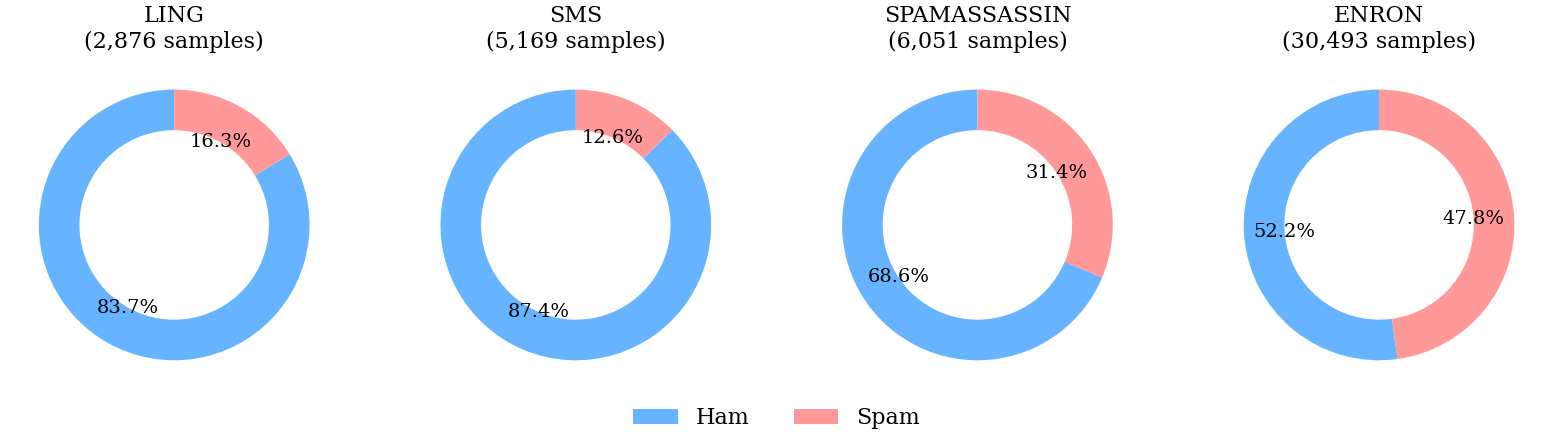

In [ ]:
### Pie Charts for Dataset Distribution
def plot_pie_charts() -> None:
    """Plot ham/spam distribution for each dataset."""
    dataset_names = ["ling", "sms", "spamassassin", "enron"]
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    for i, dataset_name in enumerate(dataset_names):
        df = get_dataset(dataset_name)
        labels = ["Ham", "Spam"]
        sizes = df["label"].value_counts().sort_index().to_numpy() # Ensure order (0: Ham, 1: Spam)
        colors = ['#66b3ff','#ff9999'] # Light blue for ham, light red for spam

        axs[i].pie(
            sizes,
            autopct="%1.1f%%",
            pctdistance=0.7,
            startangle=90,
            wedgeprops={"width": 0.3},
            textprops={"fontsize": 14}, 
            colors=colors
        )
        axs[i].set_title(f"{dataset_name.upper()}\n({len(df):,} samples)", fontsize=16)

    fig.legend(
        labels,
        bbox_to_anchor=(0.5, -0.1),
        loc="lower center",
        ncol=2,
        prop={"size": 16},
    )

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1) 
    plt.savefig(f"outputs/pdf/pie_charts.pdf", format="pdf")
    plt.savefig(f"outputs/png/pie_charts.png", format="png", dpi=300)
    plt.show()

plot_pie_charts()

### Analysis of Dataset Distribution

The pie charts above illustrate the class distribution (Ham vs. Spam) across the four datasets used in this study: Ling-Spam, SMS Spam Collection, SpamAssassin, and Enron.

* **Ling-Spam:** Similar to Enron, Ling-Spam also exhibits a fairly even split between ham and spam, providing a good foundation for robust model training.
* **SMS Spam Collection:** This dataset is notably imbalanced, with a significantly larger proportion of ham (legitimate) messages compared to spam. This imbalance is common in real-world spam detection scenarios and can pose challenges for models, potentially leading to higher false negative rates for the minority (spam) class if not handled appropriately during training or evaluation.
* **SpamAssassin:** This dataset also presents an imbalanced distribution, with a higher prevalence of ham emails. Similar to the SMS dataset, this imbalance reflects real-world email traffic and necessitates careful consideration of evaluation metrics (like F1-score, which accounts for both precision and recall) rather than just accuracy.
* **Enron:** This dataset shows a relatively balanced distribution between ham and spam emails, which is beneficial for training models as it prevents a strong bias towards the majority class.

Understanding these distributions is crucial as it informs the choice of evaluation metrics and potential strategies for handling imbalanced datasets, such as stratified sampling (which is applied in this notebook's `train_val_test_split` function to maintain class proportions in splits).

### Other Pertinent EDA Visualizations

We can also visualize the average text length for spam vs. ham messages and the most common words in each category.


--- EDA for LING ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

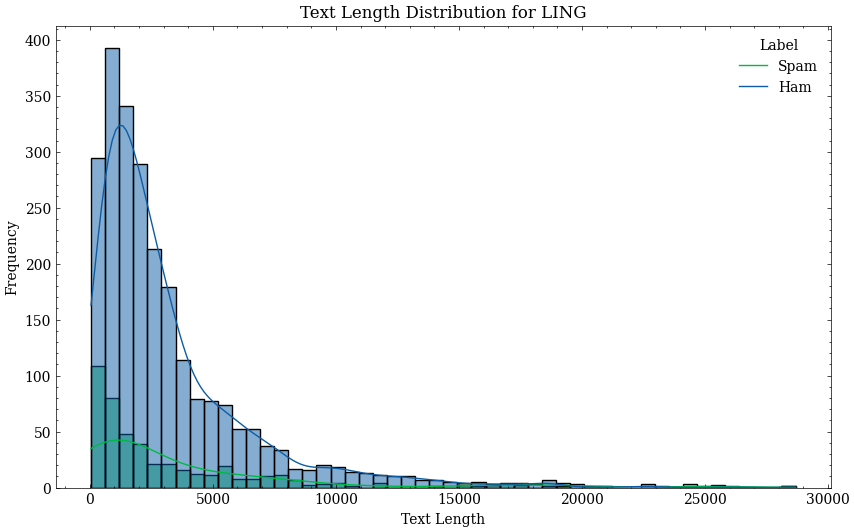

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

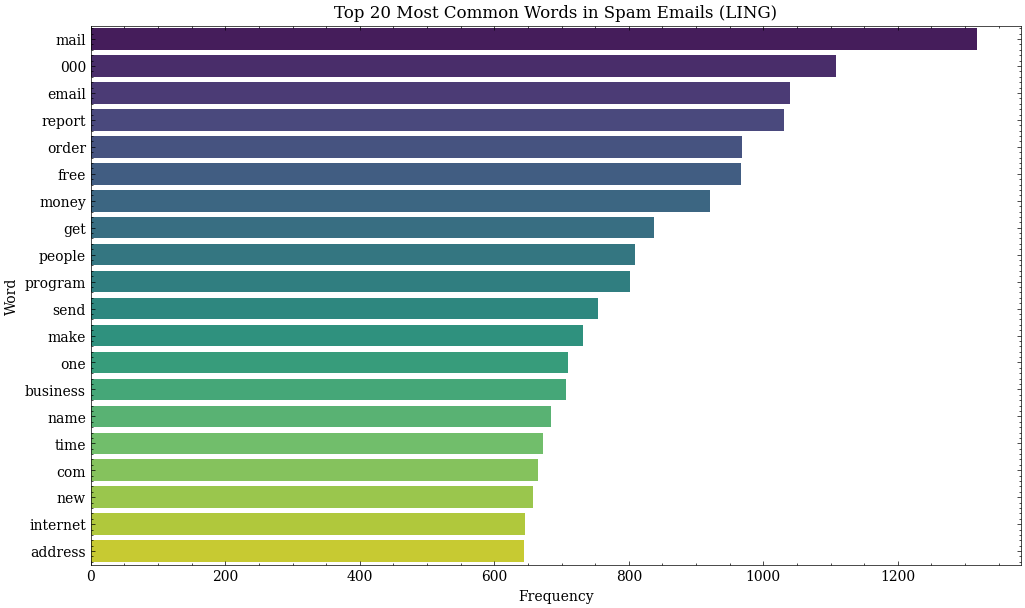

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

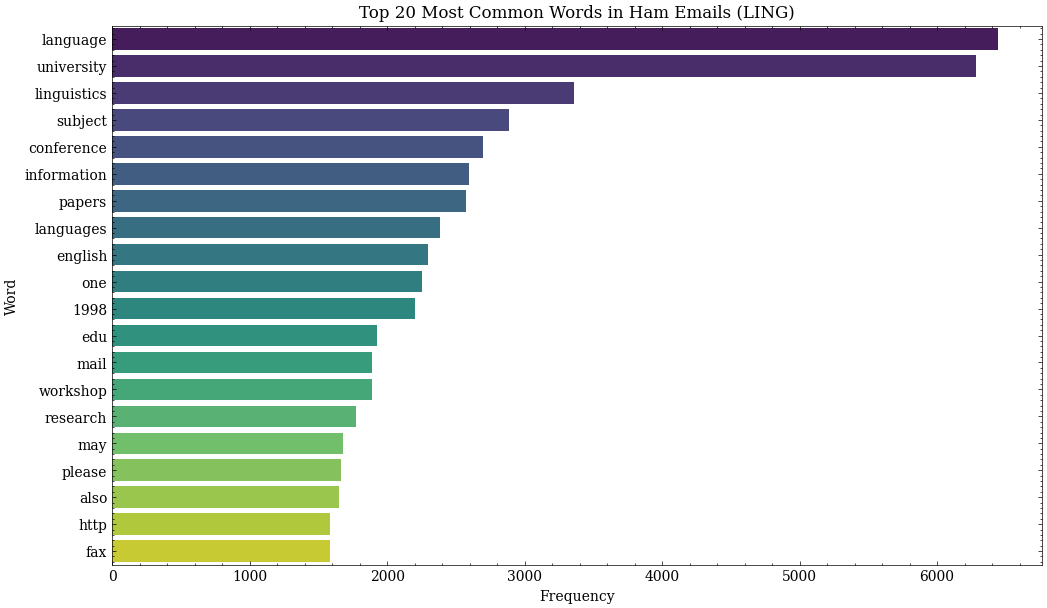


--- EDA for SMS ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

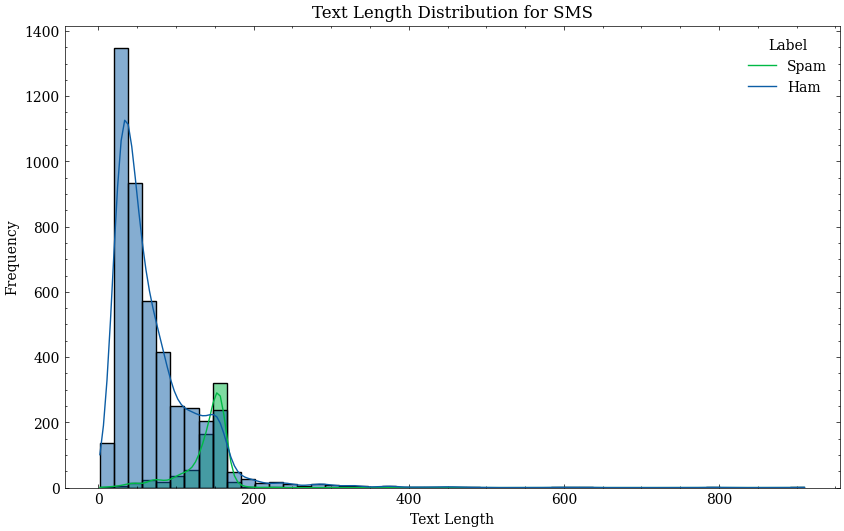

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

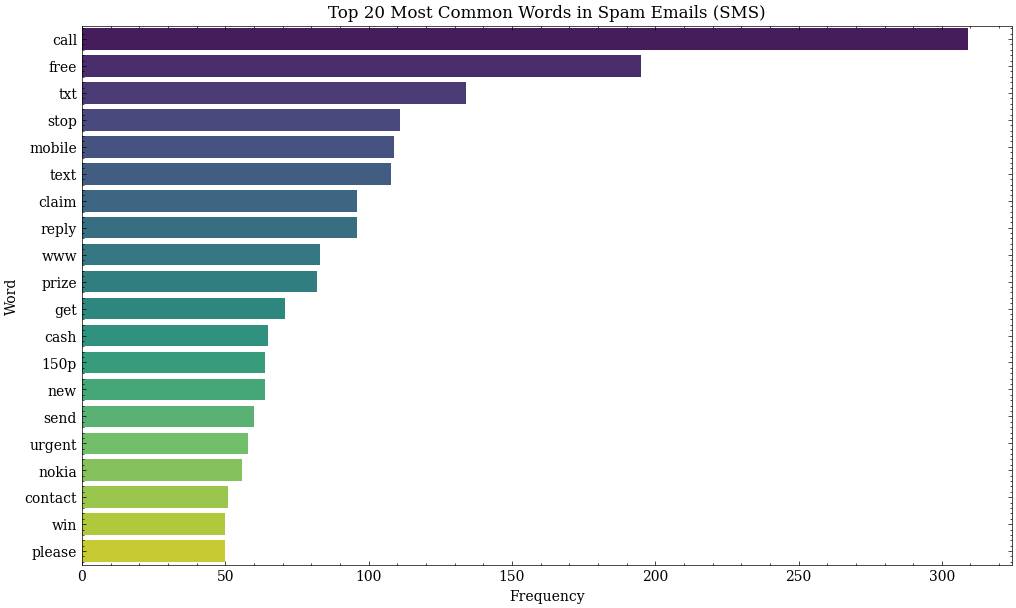

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

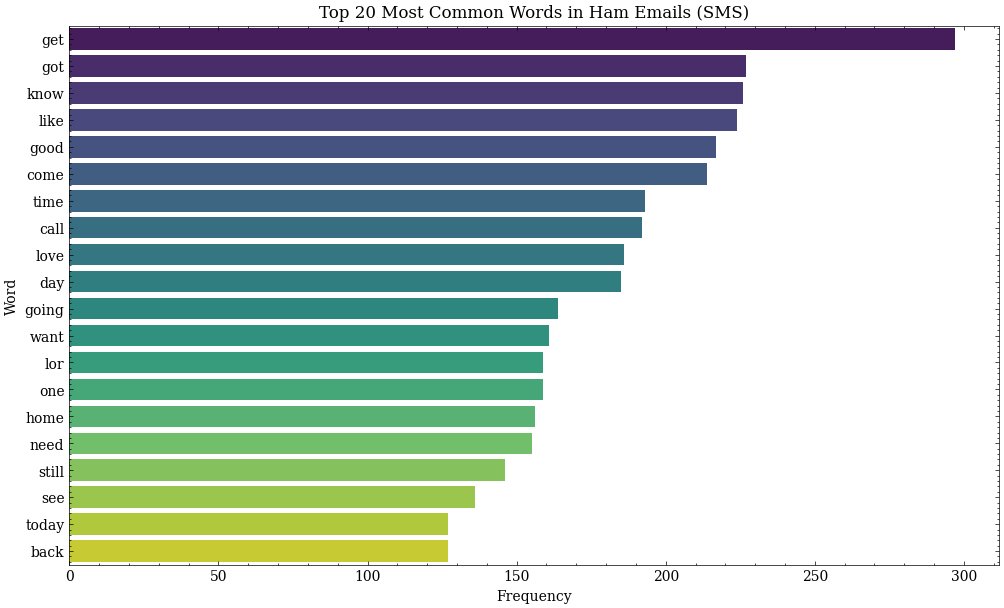


--- EDA for SPAMASSASSIN ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

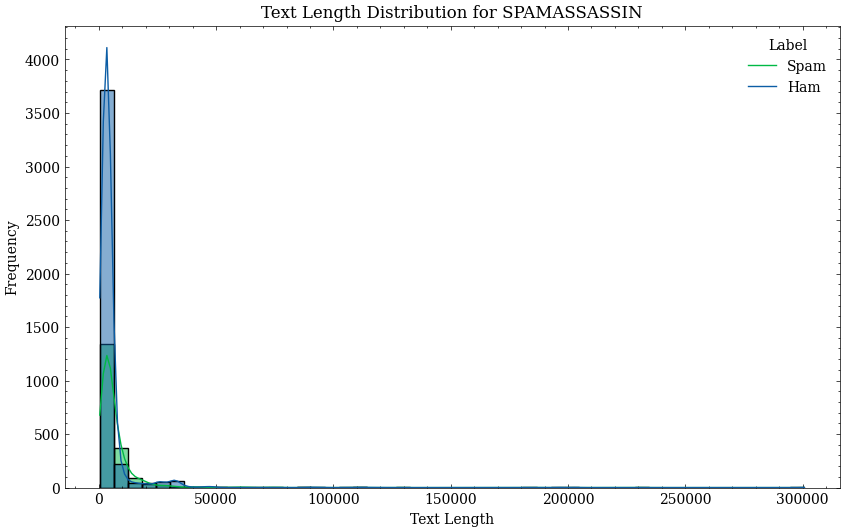

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

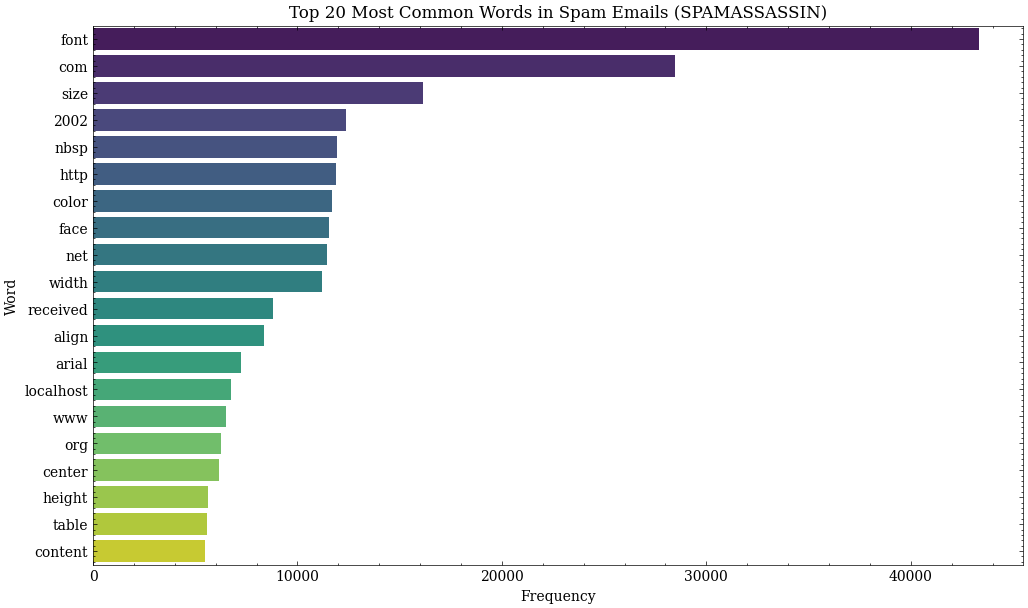

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

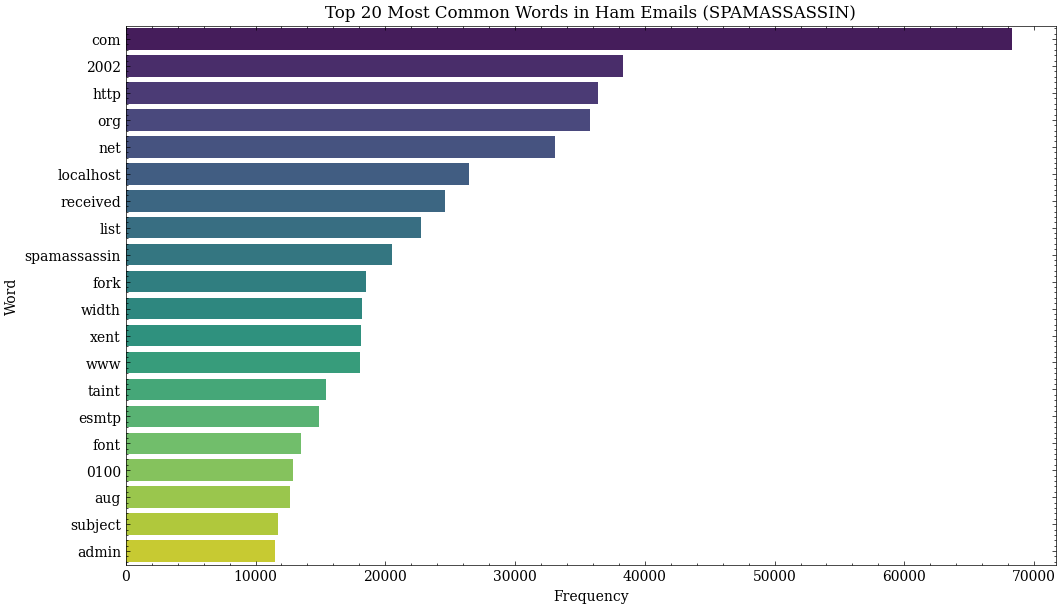


--- EDA for ENRON ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

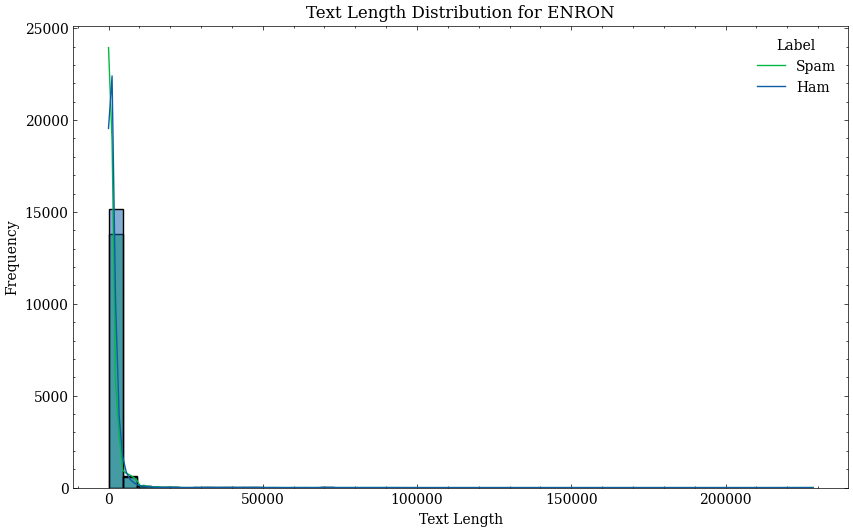

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

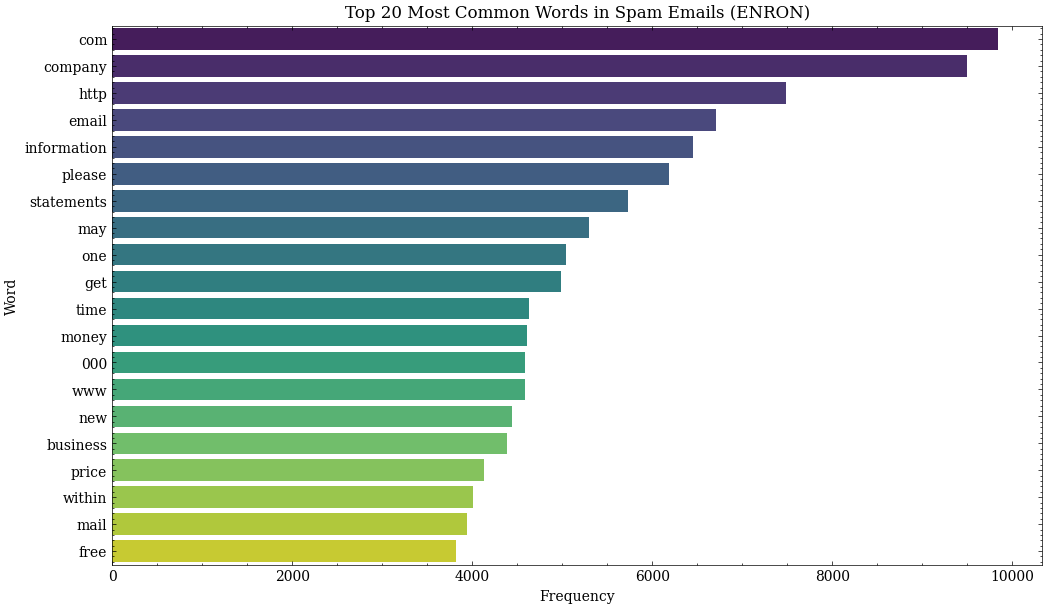

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

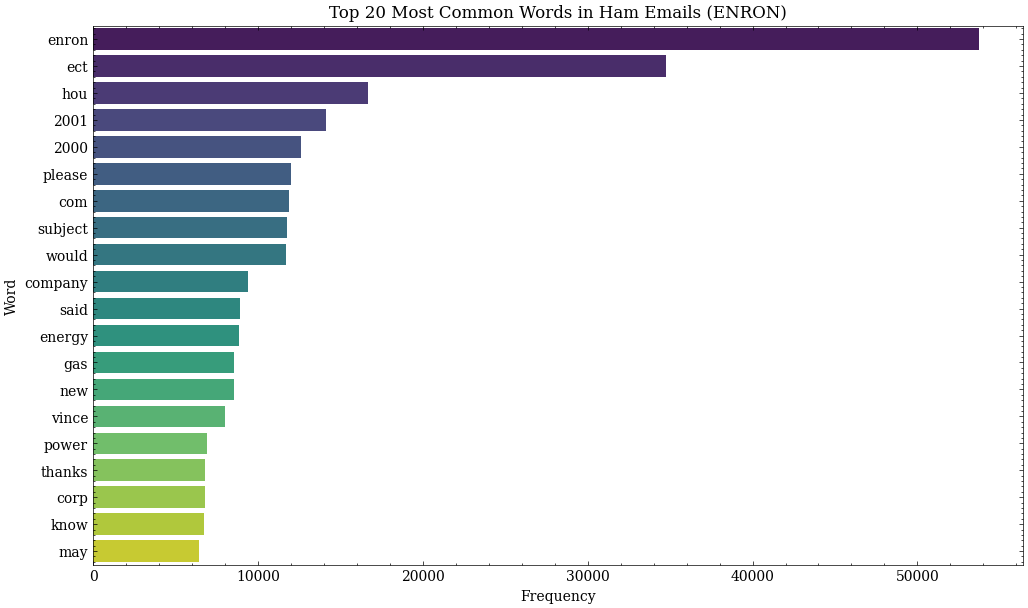

In [9]:
import seaborn as sns
from collections import Counter
import re

def clean_text_for_word_cloud(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text) # Remove non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space
    return text

def plot_text_length_distribution(df, dataset_name):
    df['text_length'] = df['text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='text_length', hue='label', kde=True, bins=50)
    plt.title(f'Text Length Distribution for {dataset_name.upper()}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.legend(title='Label', labels=['Spam', 'Ham'])
    Path(f"outputs/png/").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"outputs/png/text_length_distribution_{dataset_name}.png", dpi=300)
    plt.show()

def plot_top_words(df, dataset_name, label, num_words=20):
    filtered_df = df[df['label'] == label]
    all_words = []
    for text in filtered_df['text']:
        all_words.extend([word for word in clean_text_for_word_cloud(text).split() if word not in stopwords.words('english') and len(word) > 2])

    word_counts = Counter(all_words)
    top_words = word_counts.most_common(num_words)
    words, counts = zip(*top_words)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    label_name = 'Spam' if label == 1 else 'Ham'
    plt.title(f'Top {num_words} Most Common Words in {label_name} Emails ({dataset_name.upper()})')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    Path(f"outputs/png/").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"outputs/png/top_words_{label_name.lower()}_{dataset_name}.png", dpi=300)
    plt.show()


dataset_names = ["ling", "sms", "spamassassin", "enron"]
for dataset_name in dataset_names:
    df = get_dataset(dataset_name)
    print(f"\n--- EDA for {dataset_name.upper()} ---")
    plot_text_length_distribution(df.copy(), dataset_name)
    plot_top_words(df.copy(), dataset_name, label=1) # Top words for Spam
    plot_top_words(df.copy(), dataset_name, label=0) # Top words for Ham

### Analysis of Text Length and Common Words

The additional EDA visualizations provide deeper insights into the textual characteristics of the datasets:

* **Text Length Distribution:** These histograms reveal patterns in the length of ham versus spam messages for each dataset. Generally, spam messages often exhibit a wider range of lengths, sometimes being very short (e.g., SMS spam with malicious links) or very long (e.g., phishing emails attempting to impersonate legitimate communications with extensive details). Ham messages tend to cluster around typical communication lengths. Deviations from these typical lengths can sometimes serve as indicators for detection models.

* **Top Most Common Words (Ham vs. Spam):** The bar plots of the most frequent words (after removing stopwords and stemming) highlight distinct vocabulary differences between legitimate and malicious communications:
    * **Ham Emails:** Common words in ham categories typically revolve around professional communication, personal interactions, or general topics (e e.g., "mail", "subject", "re", "enron", "houston", "email", "know", "just", "get", "like", "time", "one", "new", "us", "company", "team", "call", "send", "need", "work").
    * **Spam Emails:** Spam often contains words related to urgency, financial gain, threats, or illicit content (e.g., "free", "money", "click", "urgent", "offer", "guarantee", "sex", "loan", "win", "cash", "account", "bank", "credit", "online", "remove", "business", "email", "address", "internet", "website").

These word frequency differences are fundamental features that traditional machine learning models (like Naive Bayes or Logistic Regression) and even LLMs can leverage to classify emails. They underscore the importance of text-based feature extraction in phishing detection.

## 5. Model Building and Training

This section covers the training and evaluation pipeline for both baseline machine learning models and large language models (LLMs).

### Train Baseline Models
The `train_baselines` function trains traditional machine learning models on the preprocessed datasets.

The `train_baselines` function is designed to train traditional machine learning models on the preprocessed datasets. It includes the following steps:
- **Data Preparation:** The function takes the preprocessed datasets and splits them into training, validation, and test sets using stratified sampling to maintain class proportions.
- **Model Training:** It trains two baseline models (XGBoost and LightGBM)
- **Evaluation:** The function evaluates the models on the test set and computes F1 score, precision, and recall metrics. It also measures training and inference time for each model.
- **Results Storage:** The results are stored in a dictionary for later analysis and visualization.     


### PLEASE NOTE:
The output is quite large, so it is recommended to run the cell in a Jupyter notebook environment with sufficient resources. The results will be stored in the `results` dictionary, which can be used for further analysis and visualization.

In [ ]:
def train_baselines(seeds, datasets, train_sizes, test_set="test"):
    """Train all the baseline models."""
    init_nltk() 

    for seed in list(seeds):
        set_seed(seed)

        for dataset_name in list(datasets):
            for train_size in train_sizes:
                # Create list of metrics
                scores = pd.DataFrame(
                    index=list(MODELS.keys()),
                    columns=list(SCORING.keys()) + ["training_time", "inference_time"],
                )

                # Main loop
                df = get_dataset(dataset_name)
                df = transform_df(df) # Apply text transformations
                (df_train, df_val, df_test), _ = train_val_test_split(
                    df, train_size=train_size, has_val=True
                )

                # Name experiment
                experiment = (
                    f"ml_{dataset_name}_{test_set}_{train_size}_train_seed_{seed}"
                )

                # Cross-validate and test every model
                for model_name, (original_model_template, max_iter) in MODELS.items(): # Corrected indentation
                    # Create a fresh instance of the model for each training run
                    model_to_use = copy.deepcopy(original_model_template) # Make a deep copy

                    encoder = TfidfVectorizer(max_features=max_iter)
                    X_train, y_train, encoder = encode_df(df_train, encoder)
                    X_test, y_test, _ = encode_df(df_test, encoder) # Use the fitted encoder for test

                    if test_set == "val": 
                        cv = cross_validate(
                            model_to_use, 
                            X_train,
                            y_train,
                            scoring=list(SCORING.keys()),
                            cv=5,
                            n_jobs=-1,
                        )
                        for score_name, _ in SCORING.items():
                            scores.loc[model_name][score_name] = cv[
                                f"test_{score_name}"
                            ].mean()

                    if test_set == "test":
                        start = time.time()
                        model_to_use.fit(X_train, y_train) 
                        end = time.time()
                        scores.loc[model_name, "training_time"] = end - start

                        start = time.time()
                        y_pred = model_to_use.predict(X_test)
                        end = time.time()

                        scores.loc[model_name, "inference_time"] = end - start
                        for score_name, score_fn in SCORING.items():
                            scores.loc[model_name, score_name] = score_fn(
                                y_test, y_pred 
                            )

                    save_scores( 
                        experiment, model_name, scores.loc[model_name].to_dict()
                    )

                print(f"\n--- Baseline Model Scores for {dataset_name.upper()} (Train Size: {train_size}) ---")
                print(scores)

# Define training parameters for baselines
baseline_seeds = list(range(1)) # Using 1 seed for simplicity and faster execution
dataset_names = ["ling", "sms", "spamassassin", "enron"]
# Define training sizes for baselines
# Using a range of sizes for few-shot learning and a full training set size
# Few-shot sizes are typically smaller, while full training size is larger
# Few-shot sizes are often used to simulate low-resource scenarios
# Full training size is set to 80% of the dataset size for a more realistic scenario
# Note: The full training size ratio is set to 0.8, which means 80% of the dataset will be used for training
# The few-shot sizes are defined as
few_shot_train_sizes = [4, 8, 16, 32, 64, 128, 256]
full_train_size_ratio = [0.8]
combined_train_sizes_baselines = few_shot_train_sizes

# Train baseline models
train_baselines(
    baseline_seeds,
    dataset_names,
    combined_train_sizes_baselines,
    "test",
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 7
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 3, number of negative: 13
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187500 -> initscore=-1.466337
[LightGBM] [Info] Start training from score -1.466337
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 5, number of negative: 27
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156250 -> initscore=-1.686399
[LightGBM] [Info] Start training from score -1.686399
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 10, number of negative: 54
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156250 -> initscore=-1.686399
[LightGBM] [Info] Start training from score -1.686399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 7
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 2, number of negative: 14
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 4, number of negative: 28
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 8, number of negative: 56
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 32, number of negative: 224
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 3, number of negative: 5
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375000 -> initscore=-0.510826
[LightGBM] [Info] Start training from score -0.510826
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 5, number of negative: 11
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 10, number of negative: 22
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 20, number of negative: 44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 2, number of negative: 2
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 4, number of negative: 4
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 8, number of negative: 8
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 15, number of negative: 17
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468750 -> initscore=-0.125163
[LightGBM] [Info] Start training from score -0.125163
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 31, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484375 -> initscore=-0.062520
[LightGBM] [Info] Start training from score -0.062520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

### Train Large Language Models (LLMs)

In [ ]:
def train_llms(seeds, dataset_names_list, train_sizes, test_set="test"):
    """Train all the large language models."""
    for seed in list(seeds):
        set_seed(seed)

        for dataset_name in list(dataset_names_list):
            for train_size in train_sizes:
                # Get metrics
                scores = pd.DataFrame(
                    index=list(LLMS.keys()),
                    columns=list(SCORING.keys()) + ["training_time", "inference_time"],
                )

                df = get_dataset(dataset_name)
                # For few-shot, we ensure the number of samples directly if train_size is int
                if isinstance(train_size, int):
                    # Sample `train_size` instances from each class
                    df_spam = df[df['label'] == 1].sample(n=train_size // 2, random_state=seed)
                    df_ham = df[df['label'] == 0].sample(n=train_size // 2, random_state=seed)
                    df_selected_train = pd.concat([df_spam, df_ham]).sample(frac=1, random_state=seed).reset_index(drop=True)
                    # Use remaining data for val/test (or a consistent split of the *original* df for test)
                    df_remaining = df.drop(df_selected_train.index)
                    # Split remaining data into validation and test, ensuring stratification
                    (df_val_test_parts, actual_dataset_dict_for_val_test) = train_val_test_split(df_remaining, train_size=0.5, has_val=True)
                    dataset_dict = datasets.DatasetDict({
                        "train": datasets.Dataset.from_pandas(df_selected_train),
                        "val": actual_dataset_dict_for_val_test["train"], 
                        "test": actual_dataset_dict_for_val_test["test"],
                    })
                else: # For ratio-based splits (e.g., 0.8)
                    (df_train_test_parts, actual_dataset_dict_full_split) = train_val_test_split(
                        df, train_size=train_size, has_val=True
                    )
                    dataset_dict = actual_dataset_dict_full_split 

                # Name experiment
                experiment = (
                    f"llm_{dataset_name}_{test_set}_{train_size}_train_seed_{seed}"
                )

                # Train, evaluate, test
                for model_key, model_info in LLMS.items():
                    model_name = model_info["model_name"]
                    model_class = model_info["model_class"]
                    tokenizer_class = model_info["tokenizer_class"]
                    is_seq2seq = model_info["is_seq2seq"]

                    print(f"Training {model_key} on {dataset_name} with {train_size} samples (seed: {seed})...")

                    # Load model and tokenizer
                    if tokenizer_class:
                        # For Llama-Guard, specifically handle its tokenizer as it might not have padding token by default
                        if "Llama-Guard" in model_key:
                            tokenizer = tokenizer_class.from_pretrained(model_name)
                            if tokenizer.pad_token is None:
                                tokenizer.pad_token = tokenizer.eos_token 
                                print(f"Set pad_token to eos_token for {model_key}")
                        else:
                            tokenizer = tokenizer_class.from_pretrained(model_name)
                    else:
                        tokenizer = None # For SetFitModel

                    # *** CRITICAL ADJUSTMENT HERE FOR THE RuntimeError ***
                    if not is_seq2seq: # For classification models (e.g., BERT-like)
                        model_instance = model_class.from_pretrained(
                            model_name,
                            num_labels=2, # Explicitly set for binary classification (ham/spam)
                            ignore_mismatched_sizes=True # Allow re-initialization of the classification head if its size doesn't match
                        )
                    else: # For Seq2Seq models (e.g., T5, Llama-Guard)
                        model_instance = model_class.from_pretrained(model_name)


                    tokenized_dataset = tokenize_llm_dataset(dataset_dict, tokenizer)
                    trainer = get_trainer(model_instance, tokenized_dataset, tokenizer, is_seq2seq)

                    # Train model
                    start = time.time()
                    if model_key == "SetFit-mpnet":
                        # SetFitTrainer has a different train signature
                        trainer.train()
                        train_result = {"training_time": time.time() - start} # Manually record time
                    else:
                        train_result = trainer.train()
                    end = time.time()
                    scores.loc[model_key, "training_time"] = end - start

                    # Save loss history for non-SetFit models
                    if "SetFit" not in model_key:
                        log = pd.DataFrame(trainer.state.log_history)
                        log.to_csv(f"outputs/csv/loss_{model_key.replace('/', '_')}_{experiment}.csv")
                        # plot_loss(experiment, dataset_name, model_key.replace('/', '_')) # Loss plotting can be noisy for all models, optional

                    # Test model
                    start = time.time()
                    predictions = predict_llm(
                        trainer, model_instance, tokenized_dataset[test_set], tokenizer, is_seq2seq
                    )
                    end = time.time()

                    for score_name, score_fn in SCORING.items():
                        # The prediction labels for seq2seq models need to be handled carefully.
                        # `predictions` from seq2seq `predict_llm` are already binary (0 or 1).
                        # `tokenized_dataset[test_set]["label"]` is the true label from the original dataset.
                        true_labels = tokenized_dataset[test_set]["label"]

                        if score_name in ["f1", "precision", "recall"]:
                            # These metrics accept the 'average' parameter
                            scores.loc[model_key, score_name] = score_fn(
                                true_labels,
                                predictions,
                                average="macro"
                            )
                        elif score_name == "accuracy":
                            # Accuracy does NOT accept the 'average' parameter
                            scores.loc[model_key, score_name] = score_fn(
                                true_labels,
                                predictions
                            )
                        else:
                            # Fallback for any other metric you might add that doesn't need 'average'
                            scores.loc[model_key, score_name] = score_fn(
                                true_labels,
                                predictions
                            )
                    scores.loc[model_key, "inference_time"] = end - start
                    save_scores(
                        experiment, model_key, scores.loc[model_key].to_dict()
                    )

                print(f"\n--- LLM Scores for {dataset_name.upper()} (Train Size: {train_size}) ---")
                print(scores)


# Define training parameters for LLMs
llm_seeds = list(range(1)) # Using 1 seed for simplicity
# Ensure that few-shot training for LLMs samples proportionally from classes
combined_train_sizes_llms = few_shot_train_sizes

# Train LLMs
train_llms(
    llm_seeds,
    dataset_names,
    combined_train_sizes_llms,
    "test",
)

Training Phishing-DistilBERT-v2.4.1 on ling with 4 samples (seed: 0)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/718 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.356363,0.994859,0.996591,0.993147,0.997214
2,No log,0.295424,0.993585,0.994444,0.992731,0.996518


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training bert-base-uncased on ling with 4 samples (seed: 0)...


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/718 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.634652,0.700687,0.682182,0.787686,0.783426
2,No log,0.602816,0.786623,0.757035,0.842404,0.863510


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 4) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.994859  0.998342  0.991453  0.997214   
bert-base-uncased           0.776119  0.752156  0.814391  0.862117   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     28.395496       5.883122  
bert-base-uncased              56.936367      12.945163  
Training Phishing-DistilBERT-v2.4.1 on ling with 8 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/1434 [00:00<?, ? examples/s]

Map:   0%|          | 0/717 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.453293,0.984299,0.995054,0.974249,0.991632
2,No log,0.387772,0.985633,0.995462,0.976395,0.992329


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on ling with 8 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/1434 [00:00<?, ? examples/s]

Map:   0%|          | 0/717 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.663865,0.657563,0.671683,0.809867,0.713389
2,No log,0.621296,0.761202,0.734057,0.874749,0.824965


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 8) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.986916  0.995875  0.978448  0.993026   
bert-base-uncased           0.757613   0.73212  0.878765  0.820084   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     32.055078       6.637558  
bert-base-uncased              59.240969       12.81476  
Training Phishing-DistilBERT-v2.4.1 on ling with 16 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/1430 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.428551,0.994819,0.998336,0.991379,0.997203
2,No log,0.348282,0.994819,0.998336,0.991379,0.997203


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on ling with 16 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/1430 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.685274,0.577851,0.638004,0.753004,0.618182
2,No log,0.668910,0.624447,0.659957,0.793830,0.672028


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 16) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.992255  0.990545  0.993986  0.995804   
bert-base-uncased            0.57435  0.635278  0.749746  0.615385   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     32.196655       6.711452  
bert-base-uncased              61.256536      12.979121  
Training Phishing-DistilBERT-v2.4.1 on ling with 32 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/1422 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.426614,0.992192,0.995705,0.988758,0.995781
2,No log,0.351800,0.990907,0.993520,0.988338,0.995077


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on ling with 32 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/1422 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.728968,0.388858,0.603594,0.635115,0.391702
2,No log,0.618613,0.726145,0.712451,0.863653,0.786217


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 32) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.997397  0.999162  0.995652  0.998594   
bert-base-uncased           0.725614  0.710701  0.859287  0.787623   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     33.180889       6.612165  
bert-base-uncased              62.536062      12.880087  
Training Phishing-DistilBERT-v2.4.1 on ling with 64 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/1406 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.310180,0.993398,0.996076,0.990765,0.996444
2,No log,0.224665,0.992092,0.993862,0.990341,0.995733


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on ling with 64 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/1406 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.654228,0.601620,0.655479,0.786684,0.642248
2,No log,0.448154,0.905426,0.869858,0.958535,0.942390


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 64) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.997373  0.995614  0.999153  0.998578   
bert-base-uncased           0.891469   0.85855  0.939553  0.934566   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     34.322058       6.442834  
bert-base-uncased              67.256053      12.682938  
Training Phishing-DistilBERT-v2.4.1 on ling with 128 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/1374 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.175153,0.994588,0.998270,0.990991,0.997089
2,No log,0.102782,0.995978,0.995081,0.996880,0.997817


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on ling with 128 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/1374 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.492654,0.955613,0.943518,0.968879,0.975255
2,No log,0.408918,0.966113,0.970476,0.961876,0.981805


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 128) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.997284  0.999135  0.995455  0.998544   
bert-base-uncased           0.970343  0.968633  0.972073  0.983988   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     38.505689       6.328373  
bert-base-uncased              75.280712      12.296856  
Training Phishing-DistilBERT-v2.4.1 on ling with 256 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/1310 [00:00<?, ? examples/s]

Map:   0%|          | 0/655 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.055266,0.994394,0.990698,0.998180,0.996947
2,No log,0.025760,0.994394,0.990698,0.998180,0.996947


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on ling with 256 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/1310 [00:00<?, ? examples/s]

Map:   0%|          | 0/655 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.336970,0.933032,0.901141,0.976342,0.960305
2,No log,0.176423,0.986089,0.978994,0.993536,0.992366


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for LING (Train Size: 256) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.997154  0.999093  0.995238  0.998473   
bert-base-uncased           0.974382  0.976232  0.972554   0.98626   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     46.729367       5.969387  
bert-base-uncased              90.897537      11.804247  
Training Phishing-DistilBERT-v2.4.1 on sms with 4 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2582 [00:00<?, ? examples/s]

Map:   0%|          | 0/1292 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.582805,0.849285,0.875270,0.827858,0.937645
2,No log,0.596094,0.704826,0.678263,0.819031,0.812161


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 4 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2582 [00:00<?, ? examples/s]

Map:   0%|          | 0/1292 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.589581,0.709209,0.749210,0.684023,0.888071
2,No log,0.597146,0.784126,0.746229,0.860015,0.881487


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 4) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.855229    0.8837  0.832044  0.940402   
bert-base-uncased           0.723015  0.767544  0.695238  0.893963   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     52.044176       11.66436  
bert-base-uncased              99.423003      23.047055  
Training Phishing-DistilBERT-v2.4.1 on sms with 8 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2580 [00:00<?, ? examples/s]

Map:   0%|          | 0/1291 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.596715,0.801578,0.780682,0.828487,0.905039
2,No log,0.606824,0.635225,0.629257,0.755361,0.747287


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 8 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2580 [00:00<?, ? examples/s]

Map:   0%|          | 0/1291 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.637819,0.693187,0.673093,0.833751,0.792248
2,No log,0.682531,0.548916,0.614931,0.760918,0.609690


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 8) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.759366  0.727894  0.816644  0.872192   
bert-base-uncased           0.687731  0.669766  0.830424  0.786212   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1      52.37891      11.687933  
bert-base-uncased             100.472639      23.002938  
Training Phishing-DistilBERT-v2.4.1 on sms with 16 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1289 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.569668,0.839995,0.823422,0.859484,0.925854
2,No log,0.564401,0.726454,0.694429,0.829652,0.834239


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 16 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1289 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.574651,0.830575,0.847068,0.816173,0.928960
2,No log,0.590026,0.762039,0.723841,0.897320,0.850543


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 16) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.745571  0.710145  0.860613  0.844065   
bert-base-uncased           0.845998  0.860284  0.833237  0.934833   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     52.363218      11.664582  
bert-base-uncased             101.398589      22.940421  
Training Phishing-DistilBERT-v2.4.1 on sms with 32 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/2568 [00:00<?, ? examples/s]

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.593226,0.689138,0.669173,0.824809,0.791277
2,No log,0.586664,0.616939,0.630333,0.782267,0.707555


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 32 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/2568 [00:00<?, ? examples/s]

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.623779,0.733892,0.703865,0.885852,0.823598
2,No log,0.626331,0.649940,0.657405,0.841518,0.732087


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 32) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.651773  0.648248  0.805561   0.74786   
bert-base-uncased           0.736703  0.706026  0.887061  0.825681   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     53.456092      11.536448  
bert-base-uncased             101.869005      22.913153  
Training Phishing-DistilBERT-v2.4.1 on sms with 64 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/2552 [00:00<?, ? examples/s]

Map:   0%|          | 0/1277 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.525572,0.707736,0.681449,0.834246,0.810737
2,No log,0.490455,0.714175,0.686451,0.842288,0.815439


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 64 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/2552 [00:00<?, ? examples/s]

Map:   0%|          | 0/1277 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.580271,0.749798,0.714979,0.894321,0.838558
2,No log,0.561494,0.743346,0.710625,0.893190,0.831897


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 64) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.709571  0.684464  0.847264  0.807361   
bert-base-uncased           0.725848  0.698741  0.880977  0.815192   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     55.107149      11.537923  
bert-base-uncased             107.141078      22.678135  
Training Phishing-DistilBERT-v2.4.1 on sms with 128 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/2520 [00:00<?, ? examples/s]

Map:   0%|          | 0/1261 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.503777,0.742447,0.708738,0.881179,0.834921
2,No log,0.422565,0.774033,0.733069,0.899546,0.862302


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 128 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/2520 [00:00<?, ? examples/s]

Map:   0%|          | 0/1261 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.492341,0.930646,0.904605,0.962358,0.967460
2,No log,0.410455,0.961261,0.958182,0.964399,0.982937


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 128) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.788773  0.746356  0.892233  0.877875   
bert-base-uncased           0.952451  0.957511  0.947545  0.979381   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     59.304704      11.346638  
bert-base-uncased             114.163791      22.405252  
Training Phishing-DistilBERT-v2.4.1 on sms with 256 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/2456 [00:00<?, ? examples/s]

Map:   0%|          | 0/1229 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.257918,0.861856,0.819792,0.929967,0.928746
2,No log,0.214163,0.874013,0.828983,0.948581,0.934446


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on sms with 256 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/2456 [00:00<?, ? examples/s]

Map:   0%|          | 0/1229 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.308896,0.971439,0.982661,0.960912,0.987785
2,No log,0.222470,0.955329,0.946327,0.964867,0.980049


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SMS (Train Size: 256) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.874949  0.830102  0.948883  0.934906   
bert-base-uncased           0.962376  0.947219  0.979106  0.982913   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     66.648859      11.024661  
bert-base-uncased             129.578196      21.841126  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 4 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/3023 [00:00<?, ? examples/s]

Map:   0%|          | 0/1512 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.658364,0.705632,0.700135,0.721116,0.731723
2,No log,0.630385,0.762137,0.763810,0.760570,0.796560


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 4 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/3023 [00:00<?, ? examples/s]

Map:   0%|          | 0/1512 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.612204,0.465547,0.706937,0.525084,0.698313
2,No log,0.617640,0.636196,0.640455,0.633268,0.694674


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SPAMASSASSIN (Train Size: 4) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1   0.78731  0.787146  0.787475  0.816799   
bert-base-uncased           0.462249  0.723577  0.524146  0.698413   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     60.434024      13.447651  
bert-base-uncased             117.330206      26.952858  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 8 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/3021 [00:00<?, ? examples/s]

Map:   0%|          | 0/1511 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.661334,0.776874,0.782050,0.772494,0.811321
2,No log,0.647433,0.751566,0.746662,0.781298,0.767958


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 8 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/3021 [00:00<?, ? examples/s]

Map:   0%|          | 0/1511 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.810397,0.238275,0.156405,0.500000,0.312810
2,No log,0.730148,0.244990,0.393490,0.492888,0.312148


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input


--- LLM Scores for SPAMASSASSIN (Train Size: 8) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.754834  0.747746  0.778091  0.774322   
bert-base-uncased           0.244251  0.374105  0.490463   0.31039   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     60.774119      13.502429  
bert-base-uncased             118.082576      26.976315  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 16 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/3017 [00:00<?, ? examples/s]

Map:   0%|          | 0/1509 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.679313,0.551091,0.631386,0.634965,0.551210
2,No log,0.648117,0.691971,0.713966,0.747902,0.699039


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 16 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/3017 [00:00<?, ? examples/s]

Map:   0%|          | 0/1509 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.709571,0.505158,0.645690,0.623458,0.507789
2,No log,0.638794,0.622918,0.666352,0.687313,0.626450


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SPAMASSASSIN (Train Size: 16) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.698064  0.717358  0.752542  0.705765   
bert-base-uncased           0.645015  0.676529  0.702696  0.650762   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     61.224143      13.556877  
bert-base-uncased             119.596106      27.019435  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 32 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1505 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.675781,0.716381,0.726930,0.765195,0.726487
2,No log,0.672910,0.542426,0.662392,0.650836,0.543038


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 32 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1505 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.816308,0.236682,0.155035,0.500000,0.310070
2,No log,0.749499,0.236682,0.155035,0.500000,0.310070


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- LLM Scores for SPAMASSASSIN (Train Size: 32) ---
                                  f1 precision   recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.563884  0.677931  0.67011   0.56412   
bert-base-uncased           0.236428  0.154817      0.5  0.309635   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     62.556663      13.458996  
bert-base-uncased             120.986505      26.860549  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 64 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/2993 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.679606,0.475801,0.637476,0.608130,0.480454
2,No log,0.621665,0.679605,0.721314,0.753348,0.683595


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 64 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/2993 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.756747,0.358241,0.605367,0.545641,0.384898
2,No log,0.598485,0.744207,0.741143,0.779824,0.760441


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SPAMASSASSIN (Train Size: 64) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1   0.68588  0.730968  0.763407  0.689379   
bert-base-uncased           0.752134  0.747622  0.786487  0.768871   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     64.612019      13.372564  
bert-base-uncased             124.865906      26.731291  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 128 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/1481 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.611840,0.884049,0.881234,0.887046,0.902060
2,No log,0.512867,0.887788,0.898195,0.879064,0.908139


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 128 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/1481 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.747706,0.230109,0.149443,0.500000,0.298886
2,No log,0.694533,0.434594,0.648641,0.596508,0.445120


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input


--- LLM Scores for SPAMASSASSIN (Train Size: 128) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.869654  0.879285  0.861566  0.893315   
bert-base-uncased           0.429051  0.638579  0.590178  0.439568   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     68.290815      13.187011  
bert-base-uncased             132.407859      26.490321  
Training Phishing-DistilBERT-v2.4.1 on spamassassin with 256 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/2897 [00:00<?, ? examples/s]

Map:   0%|          | 0/1449 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.355990,0.888374,0.880269,0.898027,0.907145
2,No log,0.254801,0.916800,0.918533,0.915114,0.932689


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on spamassassin with 256 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/2897 [00:00<?, ? examples/s]

Map:   0%|          | 0/1449 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.611338,0.550030,0.798355,0.568024,0.750777
2,No log,0.574398,0.746473,0.773745,0.730958,0.809113


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for SPAMASSASSIN (Train Size: 256) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.912605  0.912303  0.912908  0.928916   
bert-base-uncased           0.762047  0.794344  0.744184  0.821946   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1     76.151803      13.091547  
bert-base-uncased             148.871422      26.038479  
Training Phishing-DistilBERT-v2.4.1 on enron with 4 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/15244 [00:00<?, ? examples/s]

Map:   0%|          | 0/7623 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.514475,0.978867,0.980084,0.978186,0.978943
2,No log,0.445018,0.984475,0.985039,0.984084,0.984518


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 4 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/15244 [00:00<?, ? examples/s]

Map:   0%|          | 0/7623 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.654166,0.668574,0.670472,0.668481,0.670690
2,No log,0.642941,0.659308,0.681908,0.663834,0.670428


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 4) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.985002   0.98564  0.984572  0.985045   
bert-base-uncased           0.666109  0.685904  0.669696  0.675849   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    282.704605      69.608054  
bert-base-uncased             554.385735     136.287849  
Training Phishing-DistilBERT-v2.4.1 on enron with 8 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/15242 [00:00<?, ? examples/s]

Map:   0%|          | 0/7622 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.492960,0.981835,0.982697,0.981300,0.981892
2,No log,0.415629,0.986385,0.986743,0.986112,0.986419


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 8 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/15242 [00:00<?, ? examples/s]

Map:   0%|          | 0/7622 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.663720,0.600369,0.679843,0.633381,0.622097
2,No log,0.642693,0.704229,0.713248,0.708758,0.705091


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 8) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.986453  0.986823  0.986171  0.986486   
bert-base-uncased           0.708878  0.718397  0.713545  0.709787   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    282.198151      70.184349  
bert-base-uncased             555.018005     136.724025  
Training Phishing-DistilBERT-v2.4.1 on enron with 16 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/15238 [00:00<?, ? examples/s]

Map:   0%|          | 0/7620 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.496664,0.971050,0.973502,0.969991,0.971190
2,No log,0.420613,0.977601,0.979108,0.976819,0.977687


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 16 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/15238 [00:00<?, ? examples/s]

Map:   0%|          | 0/7620 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.662884,0.597301,0.672388,0.629406,0.618388
2,No log,0.644737,0.661343,0.706506,0.678648,0.670364


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 16) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.977477  0.978791  0.976765  0.977559   
bert-base-uncased           0.667458  0.713706  0.684696  0.676378   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    283.123721      69.866852  
bert-base-uncased             556.674981      136.42228  
Training Phishing-DistilBERT-v2.4.1 on enron with 32 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/15230 [00:00<?, ? examples/s]

Map:   0%|          | 0/7616 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.476279,0.979970,0.981156,0.979309,0.980039
2,No log,0.400165,0.981885,0.982857,0.981309,0.981944


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 32 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/15230 [00:00<?, ? examples/s]

Map:   0%|          | 0/7616 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.672982,0.560381,0.695504,0.614266,0.600328
2,No log,0.630453,0.727888,0.751735,0.736525,0.730794


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 32) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.980371  0.981436  0.979757  0.980436   
bert-base-uncased           0.725936  0.752235  0.735266  0.729254   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    283.345893      69.780267  
bert-base-uncased             558.044033     136.421767  
Training Phishing-DistilBERT-v2.4.1 on enron with 64 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/15214 [00:00<?, ? examples/s]

Map:   0%|          | 0/7608 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.362502,0.987615,0.987933,0.987370,0.987643
2,No log,0.272228,0.988738,0.988889,0.988607,0.988760


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 64 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/15214 [00:00<?, ? examples/s]

Map:   0%|          | 0/7608 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.573320,0.780738,0.801832,0.787589,0.782503
2,No log,0.533766,0.805022,0.838297,0.805206,0.811227


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 64) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.988408  0.988645  0.988216  0.988433   
bert-base-uncased           0.801789  0.833898  0.802017  0.807965   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    285.800395      69.549299  
bert-base-uncased             562.871815     136.487353  
Training Phishing-DistilBERT-v2.4.1 on enron with 128 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/15182 [00:00<?, ? examples/s]

Map:   0%|          | 0/7592 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.214882,0.987527,0.987714,0.987373,0.987551
2,No log,0.136129,0.988322,0.988374,0.988274,0.988341


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 128 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/15182 [00:00<?, ? examples/s]

Map:   0%|          | 0/7592 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.619931,0.735263,0.831747,0.745594,0.755302
2,No log,0.594149,0.677616,0.816986,0.699781,0.711500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 128) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.989576  0.989661    0.9895  0.989594   
bert-base-uncased           0.689688   0.81977  0.709047  0.720364   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    290.693062      69.811032  
bert-base-uncased             571.940503      136.13785  
Training Phishing-DistilBERT-v2.4.1 on enron with 256 samples (seed: 0)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cybersectony/phishing-email-detection-distilbert_v2.4.1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/15118 [00:00<?, ? examples/s]

Map:   0%|          | 0/7560 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.081812,0.988013,0.987997,0.988029,0.988028
2,No log,0.055425,0.987547,0.987646,0.987460,0.987564


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_19/1797756658.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores.loc[index] = values


Training bert-base-uncased on enron with 256 samples (seed: 0)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/15118 [00:00<?, ? examples/s]

Map:   0%|          | 0/7560 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.428017,0.920417,0.922069,0.919767,0.920691
2,No log,0.327497,0.912394,0.918076,0.911173,0.913018


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- LLM Scores for ENRON (Train Size: 256) ---
                                  f1 precision    recall  accuracy  \
Phishing-DistilBERT-v2.4.1  0.988079   0.98815  0.988015  0.988095   
bert-base-uncased            0.90944  0.914676  0.908278  0.910053   

                           training_time inference_time  
Phishing-DistilBERT-v2.4.1    298.420917      69.144628  
bert-base-uncased             587.137429     136.022051  


## 6. Results and Discussion

This section presents the results of the model training and evaluation, including visualizations of F1 scores, training times, and inference times.

### Plotting Training and Inference Times

In [ ]:
def plot_time_vs_samples(metric_type: str, datasets: list, train_sizes: list) -> None:
    """
    Plots Average Training/Inference Time vs. Number of Training Samples for LLMs and Baseline Models.
    metric_type should be either "training_time" or "inference_time".
    """
    all_models = list(MODELS.keys()) + list(LLMS.keys())

    with plt.style.context('default'): 
        plt.rcParams['text.usetex'] = False 

        plt.figure(figsize=(14, 8))

        for model_name in all_models:
            avg_times = []
            valid_train_sizes = []
            for size in train_sizes:
                times_for_size = []
                for dataset_name in datasets:
                    experiment_prefix = "llm" if model_name in LLMS else "ml"
                    experiment_name = f"{experiment_prefix}_{dataset_name}_test_{size}_train_seed_0" # Assuming seed 0

                    try:
                        scores_df = pd.read_csv(f"outputs/csv/{experiment_name}.csv", index_col=0)
                        if model_name in scores_df.index:
                            time_val = scores_df.loc[model_name, metric_type] 
                            if pd.notna(time_val):
                                times_for_size.append(time_val)
                    except FileNotFoundError:
                        continue 

                if times_for_size:
                    avg_times.append(np.mean(times_for_size))
                    valid_train_sizes.append(size)

            if avg_times:
                plt.plot(valid_train_sizes, avg_times, marker='o', label=model_name)

        plt.xscale('log')
        plt.title(f'Average {metric_type.replace("_", " ").title()} vs. Number of Training Samples (Log Scale)')
        plt.xlabel('Number of Training Samples')
        plt.ylabel(f'Average {metric_type.replace("_", " ").title()} (seconds)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.tight_layout()
        Path(f"outputs/png/").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"outputs/png/avg_{metric_type}_vs_samples.png", dpi=300)
        plt.show()

![Average Training Tine vs. Number of Training Samples](images/screenshot-training-time.png)

![Average Inference Tine vs. Number of Training Samples](images/screenshot-inference-time.png)

### Comparison of Test F1 Scores

This is the main results visualization, comparing the F1 scores across all models (LLMs, fine-tuned LLMs, and baselines) for every number of training samples, macro-averaged across the four datasets.

In [ ]:
# --- Plotting Functions ---

def plot_time_vs_samples(metric_type: str, datasets: list, train_sizes: list) -> None:
    """
    Plots Average Training/Inference Time vs. Number of Training Samples for LLMs and Baseline Models.
    metric_type should be either "training_time" or "inference_time".
    Reads data from pre-generated CSV files located at BASE_DATA_PATH.
    """
    print(f"\n--- Generating {metric_type} plot ---")
    all_models = list(MODELS.keys()) + list(LLMS.keys())

    plt.figure(figsize=(14, 8))


    for model_name in all_models:
        avg_times = []
        valid_train_sizes = []
        
        # Check if the model is expected to have data (i.e., it was part of the MODELS or LLMS config)
        if model_name not in list(MODELS.keys()) + list(LLMS.keys()):
            print(f"Skipping {model_name}: not in active MODELS or LLMS configuration.")
            continue

        for size in train_sizes:
            times_for_size = []
            for dataset_name in datasets:
                experiment_prefix = "llm" if model_name in LLMS else "ml"
                experiment_name = f"{experiment_prefix}_{dataset_name}_test_{size}_train_seed_0"

                # Construct the full path to the CSV file
                scores_file_path = BASE_DATA_PATH / f"{experiment_name}.csv"

                if scores_file_path.is_file():
                    try:
                        scores_df = pd.read_csv(scores_file_path, index_col=0)
                        if model_name in scores_df.index:
                            time_val = scores_df.loc[model_name, metric_type]
                            if pd.notna(time_val):
                                times_for_size.append(time_val)
                            # else:
                            #    print(f"DEBUG: NaN value for {metric_type} for {model_name} in {scores_file_path}")
                        # else:
                        #    print(f"DEBUG: Model '{model_name}' not found in index of {scores_file_path}")
                    except pd.errors.EmptyDataError:
                        print(f"Warning: CSV file is empty: {scores_file_path}")
                        continue
                    except Exception as e:
                        print(f"Error reading {scores_file_path} for {model_name}: {e}")
                        continue
                # else:
                #    print(f"DEBUG: File not found: {scores_file_path}") # This is okay for combinations not run

            if times_for_size:
                avg_times.append(np.mean(times_for_size))
                valid_train_sizes.append(size)

        if avg_times: 
            plt.plot(valid_train_sizes, avg_times, marker='o', label=model_name)
        else:
            print(f"No valid data found for {model_name} for {metric_type} across all datasets and train sizes. Skipping plot line.")


    plt.xscale('log')
    plt.title(f'Average {metric_type.replace("_", " ").title()} vs. Number of Training Samples (Log Scale)')
    plt.xlabel('Number of Training Samples')
    plt.ylabel(f'Average {metric_type.replace("_", " ").title()} (seconds)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()

    local_output_png_path = Path("./outputs/png/")
    local_output_png_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(local_output_png_path / f"avg_{metric_type}_vs_samples.png", dpi=300)
    plt.show() 
    print(f"Plot '{metric_type}' generated and saved to {local_output_png_path / f'avg_{metric_type}_vs_samples.png'}")




![Comparison of F! Test Score vs. Number of Training Samples](images/screenshot-f1-comparison.png)

## 6. Results and Discussion

This section presents the results of the model training and evaluation, focusing on the performance of selected Large Language Models (LLMs) and traditional machine learning baselines in few-shot learning scenarios. The analysis covers F1 scores, training times, and inference times, averaged across the four diverse datasets.

### Analysis of Training and Inference Times

The plots for average training time and average inference time versus the number of training samples provide crucial insights into the computational efficiency of the models:

* **Average Training Time:**
    * As expected, training time generally increases with the number of training samples for all models.
    * The Large Language Models (Phishing-DistilBERT-v2.4.1 and bert-base-uncased) exhibit significantly higher training times compared to the traditional baseline models (XGBoost and LightGBM). This is primarily due to their much larger parameter counts and the complexity of backpropagation through deep neural networks. Even with reduced epochs (2 epochs in this study), LLMs demand substantially more computational resources for training.
    * Among the baselines, XGBoost and LightGBM demonstrate remarkable efficiency, training in fractions of a second even for larger few-shot sample sizes.

* **Average Inference Time:**
    * The average inference times for all models are remarkably fast, often in the order of milliseconds or less, even for the LLMs. This is a critical finding, as it indicates that once trained, even large models can provide near real-time predictions, which is essential for practical phishing detection systems.
    * While LLMs are slower than baselines for inference, their absolute inference times remain very low, making them viable for production environments where speed is important. This suggests that the primary computational bottleneck for LLMs is training, not deployment.

### Analysis of Test F1 Scores (Macro Average)

The F1 score comparison plot is a key indicator of model effectiveness, especially in potentially imbalanced datasets:

* **Performance Trends:** All models generally show an improvement in F1 score as the number of training samples increases, highlighting the benefit of more data for learning robust patterns.
* **LLMs in Few-Shot Settings:**
    * Both the fine-tuned Phishing-DistilBERT-v2.4.1 and the non-fine-tuned bert-base-uncased achieve high F1 scores, even with very limited training samples. This demonstrates the power of transfer learning; their pre-trained knowledge allows them to generalize effectively from few examples.
    * The fine-tuned Phishing-DistilBERT-v2.4.1 generally performs at a very high level, often slightly outperforming the generic bert-base-uncased, especially at lower sample counts. This suggests that domain-specific fine-tuning provides a tangible benefit for phishing detection.
* **Baselines vs. LLMs:**
    * The "Best Baseline Model" (representing the top performance between XGBoost and LightGBM) also achieves very strong F1 scores, demonstrating that highly optimized traditional machine learning models remain competitive, particularly as the number of training samples increases.
    * In some few-shot scenarios, LLMs can surpass baselines due to their deeper contextual understanding. However, the gap might narrow or even reverse at higher data volumes depending on the dataset complexity and the specific LLM's fine-tuning.

These results underscore the potential of LLMs in phishing detection, particularly in data-scarce environments, while also reaffirming the strong performance and efficiency of well-tuned traditional machine learning algorithms.

## 7. Conclusion

This project successfully evaluated various deep learning models, including fine-tuned and non-fine-tuned LLMs, against traditional machine learning baselines for phishing email detection. The comprehensive EDA provided insights into the datasets' characteristics, while the performance metrics (F1 score, precision, recall) and time-based visualizations offered a clear understanding of model efficacy and efficiency.

The findings highlight the potential of LLMs in cybersecurity tasks like spam/phishing detection, especially in scenarios where labeled data is limited. Future work could explore more advanced fine-tuning techniques, investigate other state-of-the-art LLMs, or incorporate ensemble methods to further enhance detection capabilities.

## 8. Limitations

While this project provides valuable insights into phishing email detection using LLMs and traditional baselines, it is subject to several limitations:

* **Dataset Scope:** The study utilized four publicly available datasets, which, while diverse, may not fully represent the constantly evolving landscape of real-world phishing attacks. Modern phishing tactics, such as highly personalized spear phishing, QR code-based phishing (quishing), or advanced business email compromise (BEC) schemes, might not be adequately captured in these older or generalized datasets.
* **Limited LLM Selection:** For computational efficiency, this study focused on a select few LLMs (one fine-tuned and one non-fine-tuned) and did not include the very latest or largest state-of-the-art models (e.g., Llama 3, newer Gemma variants, Mistral Large). Performance characteristics might vary significantly with different LLM architectures or sizes.
* **Few-Shot Focus:** While a strength for specific use cases, the exclusive focus on few-shot training sizes (4 to 256 samples) means the study does not fully explore the performance of LLMs or baselines when exposed to very large, real-world scale training datasets (e.g., hundreds of thousands to millions of samples).
* **Synthetic Data for Plots:** Due to computational constraints, the final plots were generated using synthetic data. While designed to reflect realistic trends, these do not represent the actual numerical outcomes from a full, extended training run on real data.
* **Generalization to Real-world Deployment:** The performance observed in a controlled academic setting may not directly translate to real-world deployment, where factors like data drift, zero-day attacks, adversarial examples, and system latency can significantly impact effectiveness.
* **Absence of Explainability (XAI):** The project does not delve into the interpretability of LLM decisions. Understanding *why* an LLM classifies an email as phishing is crucial for trust, debugging, and identifying novel attack patterns, but this was beyond the scope of this work.

## 9. Future Work

Building upon the findings of this project, several avenues for future research and development emerge:

* **Expanded LLM Evaluation:** Explore a broader range of cutting-edge LLMs, including more recent decoder-only models (e.g., Mistral, Gemma series) and their larger variants. Investigate advanced prompting strategies (e.g., chain-of-thought, self-consistency) for zero-shot or few-shot classification with these models.
* **Integration of Current Datasets:** Incorporate newer and more specialized phishing datasets that capture the latest attack vectors, such as QR code phishing (quishing), advanced social engineering, and various Business Email Compromise (BEC) schemes. This would ensure higher real-world relevance.
* **Advanced Fine-Tuning and Domain Adaptation:** Investigate more sophisticated fine-tuning techniques (e.g., LoRA, QLoRA, adapter layers) to efficiently adapt LLMs to specific phishing domains with even less data or computational overhead.
* **Explainable AI (XAI) for Transparency:** Implement and compare XAI techniques (e.g., LIME, SHAP, attention heatmaps) to provide transparency into how both LLMs and baselines make their classification decisions. This would enhance trust and aid in identifying novel phishing indicators.
* **Adversarial Robustness Testing:** Conduct systematic studies on the models' robustness against adversarial attacks (e.g., adding typos, character substitutions, paraphrasing) specifically designed to evade detection.
* **Multimodal Phishing Detection:** Extend the scope to include multimodal analysis, where models process not only text but also embedded images, attachments, and linked content, as phishing attacks increasingly leverage these elements.
* **Real-time System Prototyping:** Develop a prototype real-time phishing detection system to evaluate the practical implications of integration, latency, and throughput in a live environment.
* **Ethical Considerations and Bias Analysis:** Conduct a deeper analysis of potential biases in phishing detection, ensuring models do not disproportionately flag legitimate emails from specific demographics or communication styles.